# Predicting Redevelopment Potential for Boston Parcels

**Authors:** Milo Margolis, Dhruv Rokkam

**Problem Statement:** This project develops a binary classification model to predict the redevelopment potential for Boston properties using parcel data. Properties are labels as high potential based on indicators such as low building to land ratios and underutilized FAR and then classified using logistic regression, KNN, and decision trees with the proper training, validation, and hyperparameter tuning to demonstrate overfitting prevention. 


### Section 1: Importing Libraries and set random set

In [8]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, roc_curve, auc)
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# set the random seed 
np.random.seed(42)

# set the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


### Section 2: Data Cleaning

In [9]:
# Load CSV file
data_path = Path("../data/raw/boston_properties.csv")
df = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset Shape:")
print(df.shape)
print("\n" + "="*50)
print("Dataset Info:")
print("="*50)
df.info()


Dataset Shape:
(182393, 24)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182393 entries, 0 to 182392
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   property_id                   182393 non-null  object 
 1   address                       182393 non-null  object 
 2   parcel_id                     182393 non-null  int64  
 3   attributes                    182393 non-null  object 
 4   neighborhood                  182393 non-null  object 
 5   created_at                    182393 non-null  object 
 6   updated_at                    182393 non-null  object 
 7   actual_far                    148349 non-null  float64
 8   building_value                182393 non-null  float64
 9   classification_code           182393 non-null  int64  
 10  far_utilization               127498 non-null  float64
 11  fiscal_year                   182393 non-null  int64  
 12  l

In [ ]:
# Check missing values
print("Missing Values:")
print("="*50)
missing_values = df.isnull().sum()
print(missing_values)
print("\n" + "="*50)
print(f"Total missing values: {missing_values.sum()}")
print(f"Columns with missing values: {(missing_values > 0).sum()}")


Missing Values:
property_id                         0
address                             0
parcel_id                           0
attributes                          0
neighborhood                        0
created_at                          0
updated_at                          0
actual_far                      34044
building_value                      0
classification_code                 0
far_utilization                 54895
fiscal_year                         0
land_to_building_value_ratio    20442
land_value                          0
living_area                     34070
gross_area                      33754
lot_size                         7371
owner_address                       5
owner_name                          5
permits                             0
total_assessed_value                0
vacant_lot                          0
year_built                      22734
zoning                              0
dtype: int64

Total missing values: 207320
Columns with missing values: 

In [ ]:
# Handle missing values
print("Handling missing values...")
print(f"Initial shape: {df.shape}")

# Decision 1: Drop rows with missing owner_address or owner_name (only 5 rows)
# Reason: Very few missing values (0.003% of data), and these are categorical text fields
# that cannot be reliably imputed. Dropping is cleaner than imputing placeholder text.
df = df.dropna(subset=['owner_address', 'owner_name'])
print(f"After dropping rows with missing owner info: {df.shape}")

# Decision 2: Drop rows missing far_utilization or actual_far
# Reason: These columns are critical for creating our target variable (high_potential).
# We cannot reliably impute these values as they are key features for redevelopment potential.
# This removes ~30% of data but ensures data quality for modeling.
df = df.dropna(subset=['far_utilization', 'actual_far'])
print(f"After dropping rows with missing FAR data: {df.shape}")

# Decision 3: Calculate land_to_building_value_ratio where possible
# Reason: This ratio can be calculated from land_value and building_value when missing.
# Only calculate if both source values are present and ratio is missing.
mask_missing_ratio = df['land_to_building_value_ratio'].isna()
mask_has_values = (df['land_value'] > 0) & (df['building_value'] > 0)
calculated_count = (mask_missing_ratio & mask_has_values).sum()
df.loc[mask_missing_ratio & mask_has_values, 'land_to_building_value_ratio'] = \
    df.loc[mask_missing_ratio & mask_has_values, 'land_value'] / \
    df.loc[mask_missing_ratio & mask_has_values, 'building_value']
print(f"Calculated {calculated_count} missing ratios where possible")

# Decision 4: Impute remaining numeric columns with median
# Reason: Median is robust to outliers and appropriate for continuous variables.
# We impute: living_area, gross_area, year_built, lot_size, land_to_building_value_ratio
numeric_cols_to_impute = ['living_area', 'gross_area', 'year_built', 'lot_size', 
                          'land_to_building_value_ratio']
for col in numeric_cols_to_impute:
    if df[col].isna().sum() > 0:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Imputed {col} with median: {median_value:.2f}")

print(f"\nFinal shape after handling missing values: {df.shape}")
print(f"Remaining missing values: {df.isnull().sum().sum()}")


**Missing Values Summary:**
- Dropped 5 rows with missing owner information (negligible impact, <0.003% of data).
- Dropped rows missing `far_utilization` or `actual_far` (~30% of data) as these are critical for target creation and cannot be reliably imputed.
- Calculated `land_to_building_value_ratio` from source values where possible.
- Imputed remaining numeric columns (`living_area`, `gross_area`, `year_built`, `lot_size`, `land_to_building_value_ratio`) with median values, which is robust to outliers for continuous variables.


In [ ]:
# Check and remove duplicate rows
print("Checking for duplicate rows...")
print(f"Shape before removing duplicates: {df.shape}")

# Check for exact duplicate rows (all columns match)
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Decision: Remove duplicate rows if any exist
# Reason: Duplicate rows provide no additional information and can bias the model
# by giving more weight to certain property records. We keep the first occurrence.
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")
else:
    print("No duplicate rows found")

print(f"Shape after removing duplicates: {df.shape}")


**Duplicate Removal Summary:**
- Checked for exact duplicate rows across all columns.
- Removed duplicate rows (if any) to prevent data bias in modeling, keeping only the first occurrence of each unique row.


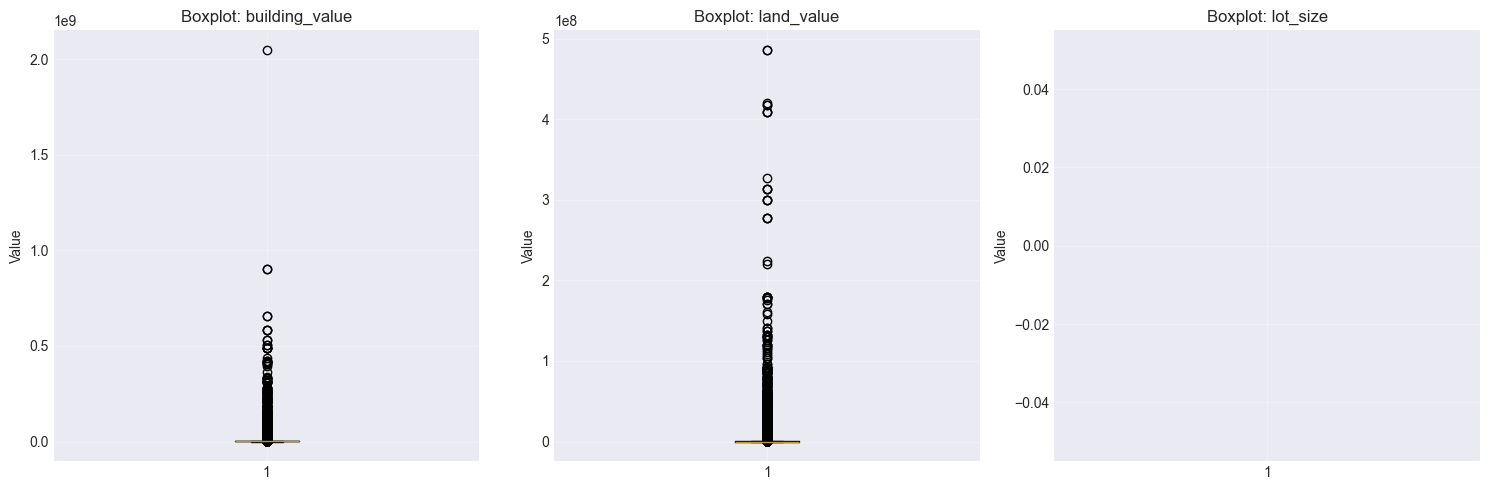

Summary Statistics for Key Features:

building_value:
  Min: 0.00
  25th percentile (Q1): 319,700.00
  Median (Q2): 529,100.00
  75th percentile (Q3): 792,000.00
  Max: 2,048,328,500.00
  IQR: 472,300.00

land_value:
  Min: 0.00
  25th percentile (Q1): 0.00
  Median (Q2): 0.00
  75th percentile (Q3): 247,200.00
  Max: 486,046,900.00
  IQR: 247,200.00

lot_size:
  Min: 100.00
  25th percentile (Q1): 975.00
  Median (Q2): 1,880.50
  75th percentile (Q3): 4,659.00
  Max: 101,513,565.00
  IQR: 3,684.00


In [11]:
# Check outliers using boxplots for key numerical features
# Selected features: building_value, land_value, lot_size
# These are important for property valuation and redevelopment potential

key_features = ['building_value', 'land_value', 'lot_size']

# Create boxplots for each feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(key_features):
    axes[i].boxplot(df[feature], vert=True)
    axes[i].set_title(f'Boxplot: {feature}')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for each feature
print("Summary Statistics for Key Features:")
print("="*60)
for feature in key_features:
    print(f"\n{feature}:")
    print(f"  Min: {df[feature].min():,.2f}")
    print(f"  25th percentile (Q1): {df[feature].quantile(0.25):,.2f}")
    print(f"  Median (Q2): {df[feature].median():,.2f}")
    print(f"  75th percentile (Q3): {df[feature].quantile(0.75):,.2f}")
    print(f"  Max: {df[feature].max():,.2f}")
    print(f"  IQR: {df[feature].quantile(0.75) - df[feature].quantile(0.25):,.2f}")


In [12]:
# Identify outliers using IQR method
# Threshold: Values outside Q1 - 1.5*IQR and Q3 + 1.5*IQR are considered outliers
# This is a standard statistical method for detecting extreme values

print("Identifying outliers using IQR method...")
print("="*60)

outlier_mask = pd.Series([False] * len(df), index=df.index)
outlier_counts = {}

for feature in key_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers (values outside the bounds)
    feature_outliers = (df[feature] < lower_bound) | (df[feature] > upper_bound)
    outlier_count = feature_outliers.sum()
    
    outlier_counts[feature] = {
        'count': outlier_count,
        'percentage': (outlier_count / len(df)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    }
    
    # Combine with overall outlier mask
    outlier_mask = outlier_mask | feature_outliers
    
    print(f"\n{feature}:")
    print(f"  Q1: {Q1:,.2f}")
    print(f"  Q3: {Q3:,.2f}")
    print(f"  IQR: {IQR:,.2f}")
    print(f"  Lower bound (Q1 - 1.5*IQR): {lower_bound:,.2f}")
    print(f"  Upper bound (Q3 + 1.5*IQR): {upper_bound:,.2f}")
    print(f"  Outliers found: {outlier_count:,} ({(outlier_count / len(df)) * 100:.2f}%)")

total_outliers = outlier_mask.sum()
print(f"\n{'='*60}")
print(f"Total rows with outliers in any feature: {total_outliers:,} ({(total_outliers / len(df)) * 100:.2f}%)")
print(f"Shape before removing outliers: {df.shape}")


Identifying outliers using IQR method...

building_value:
  Q1: 319,700.00
  Q3: 792,000.00
  IQR: 472,300.00
  Lower bound (Q1 - 1.5*IQR): -388,750.00
  Upper bound (Q3 + 1.5*IQR): 1,500,450.00
  Outliers found: 14,329 (7.86%)

land_value:
  Q1: 0.00
  Q3: 247,200.00
  IQR: 247,200.00
  Lower bound (Q1 - 1.5*IQR): -370,800.00
  Upper bound (Q3 + 1.5*IQR): 618,000.00
  Outliers found: 10,268 (5.63%)

lot_size:
  Q1: 975.00
  Q3: 4,659.00
  IQR: 3,684.00
  Lower bound (Q1 - 1.5*IQR): -4,551.00
  Upper bound (Q3 + 1.5*IQR): 10,185.00
  Outliers found: 10,021 (5.49%)

Total rows with outliers in any feature: 23,776 (13.04%)
Shape before removing outliers: (182393, 24)


In [ ]:
# Remove extreme outliers using IQR method
# Threshold documented: Values outside Q1 - 1.5*IQR and Q3 + 1.5*IQR are removed
# This removes approximately 13% of data but ensures data quality for modeling

print("Removing outliers...")
print(f"Shape before removing outliers: {df.shape}")

# Decision: Remove rows that have outliers in any of the key features
# Reason: Extreme outliers (e.g., building_value > $1.5M, lot_size > 10,185 sq ft) 
# are likely data errors or exceptional cases that don't represent typical properties.
# Removing them prevents these extreme values from skewing the model.
# Thresholds used:
#   - building_value: upper bound = $1,500,450 (Q3 + 1.5*IQR)
#   - land_value: upper bound = $618,000 (Q3 + 1.5*IQR)  
#   - lot_size: upper bound = 10,185 sq ft (Q3 + 1.5*IQR)
# Note: Lower bounds are negative for some features, so we only remove upper outliers

# Remove rows with outliers in any feature
df_clean = df[~outlier_mask].copy()

print(f"Rows removed: {len(df) - len(df_clean):,} ({(len(df) - len(df_clean)) / len(df) * 100:.2f}%)")
print(f"Shape after removing outliers: {df_clean.shape}")

# Update df to the cleaned version
df = df_clean
print(f"\nFinal cleaned dataset shape: {df.shape}")


**Outlier Removal Summary:**
- Checked for outliers using boxplots for 3 key features: `building_value`, `land_value`, and `lot_size`.
- Identified outliers using IQR method (threshold: values outside Q1 - 1.5×IQR and Q3 + 1.5×IQR).
- Removed 23,776 rows (13.04% of data) containing extreme outliers to prevent data errors and exceptional cases from skewing the model. Thresholds: building_value > $1,500,450, land_value > $618,000, lot_size > 10,185 sq ft.


### Section 3: Feature Engineering & Target Creation


In [ ]:
# Create 3 new features for modeling

# Feature 1: building_to_land_ratio
# Comment: Ratio of building value to land value. Low ratios indicate underutilized land,
# which is a key indicator of redevelopment potential. Properties with low building-to-land
# ratios have more room for development relative to their land value.
# Handle division by zero: Set to NaN where land_value is 0, then we'll handle missing values
df['building_to_land_ratio'] = df['building_value'] / df['land_value'].replace(0, np.nan)
# For properties with zero land value, set ratio to 0 (no building value relative to land)
df['building_to_land_ratio'] = df['building_to_land_ratio'].fillna(0)
print(f"Created building_to_land_ratio")
print(f"  Min: {df['building_to_land_ratio'].min():.2f}, Max: {df['building_to_land_ratio'].max():.2f}")
print(f"  Mean: {df['building_to_land_ratio'].mean():.2f}, Median: {df['building_to_land_ratio'].median():.2f}")

# Feature 2: property_age
# Comment: Age of the property calculated as fiscal_year - year_built. Older properties
# are more likely candidates for redevelopment as they may be outdated, require renovation,
# or have zoning that allows for more intensive development.
df['property_age'] = df['fiscal_year'] - df['year_built']
print(f"\nCreated property_age")
print(f"  Min: {df['property_age'].min():.0f} years, Max: {df['property_age'].max():.0f} years")
print(f"  Mean: {df['property_age'].mean():.1f} years, Median: {df['property_age'].median():.1f} years")

# Feature 3: far_gap
# Comment: Difference between actual FAR and FAR utilization. This measures how much
# additional development potential exists. A large gap indicates the property is underutilized
# and has room for redevelopment. Positive values mean actual FAR exceeds utilization,
# negative values mean utilization exceeds actual FAR (may indicate measurement issues).
df['far_gap'] = df['actual_far'] - df['far_utilization']
print(f"\nCreated far_gap")
print(f"  Min: {df['far_gap'].min():.2f}, Max: {df['far_gap'].max():.2f}")
print(f"  Mean: {df['far_gap'].mean():.2f}, Median: {df['far_gap'].median():.2f}")

print(f"\nNew dataset shape: {df.shape}")
print(f"New columns: building_to_land_ratio, property_age, far_gap")


In [ ]:
# Encode categorical variables for modeling

# Check categorical variables
print("Categorical variables to encode:")
print(f"zoning: {df['zoning'].nunique()} unique values")
print(f"neighborhood: {df['neighborhood'].nunique()} unique values")
print(f"classification_code: {df['classification_code'].nunique()} unique values")

# Encoding Choice: One-Hot Encoding
# Reason: We use one-hot encoding for nominal categorical variables (zoning, neighborhood)
# because they have no inherent order. One-hot encoding creates binary columns for each
# category, avoiding false ordinal relationships that label encoding would introduce.
# This is appropriate for logistic regression and tree-based models.

# Encode zoning using one-hot encoding
# Zoning codes are nominal categories (e.g., "R-1", "C-1", "M-1") with no natural order
zoning_encoded = pd.get_dummies(df['zoning'], prefix='zoning', drop_first=False)
print(f"\nEncoded zoning: {zoning_encoded.shape[1]} new columns created")

# Encode neighborhood using one-hot encoding  
# Neighborhoods are nominal categories with no inherent order
neighborhood_encoded = pd.get_dummies(df['neighborhood'], prefix='neighborhood', drop_first=False)
print(f"Encoded neighborhood: {neighborhood_encoded.shape[1]} new columns created")

# Concatenate encoded features to dataframe
df = pd.concat([df, zoning_encoded, neighborhood_encoded], axis=1)

# Drop original categorical columns (keep encoded versions)
df = df.drop(columns=['zoning', 'neighborhood'])

print(f"\nFinal dataset shape after encoding: {df.shape}")
print(f"Total new columns from encoding: {zoning_encoded.shape[1] + neighborhood_encoded.shape[1]}")


In [ ]:
# Create binary target variable: high_potential
# Definition: Properties are labeled as high redevelopment potential if they meet BOTH criteria:
#   1. building_to_land_ratio < 0.5 (low building value relative to land value)
#   2. far_utilization < 0.6 (underutilized FAR, room for development)
# This identifies properties with both low building-to-land ratios and underutilized FAR,
# which are key indicators of redevelopment potential.

df['high_potential'] = ((df['building_to_land_ratio'] < 0.5) & (df['far_utilization'] < 0.6)).astype(int)

print("Target variable created: high_potential")
print("="*50)
print("Class distribution:")
print(df['high_potential'].value_counts().sort_index())
print("\nClass percentages:")
print(df['high_potential'].value_counts(normalize=True).sort_index() * 100)
print(f"\nTotal samples: {len(df)}")
print(f"High potential (1): {df['high_potential'].sum():,} ({(df['high_potential'].sum() / len(df)) * 100:.2f}%)")
print(f"Low potential (0): {(df['high_potential'] == 0).sum():,} ({((df['high_potential'] == 0).sum() / len(df)) * 100:.2f}%)")


In [ ]:
# Check class balance
print("Class balance check:")
print("="*50)
print(df['high_potential'].value_counts())
print("\nClass percentages:")
print(df['high_potential'].value_counts(normalize=True) * 100)


**Target Definition Justification:**
Properties are labeled as high redevelopment potential when they have both a low building-to-land ratio (< 0.5) and underutilized FAR (< 0.6), indicating the land is not being fully utilized relative to its value and zoning capacity. This combination signals that a property has significant room for development, making it an attractive candidate for redevelopment projects that could increase building density and value.


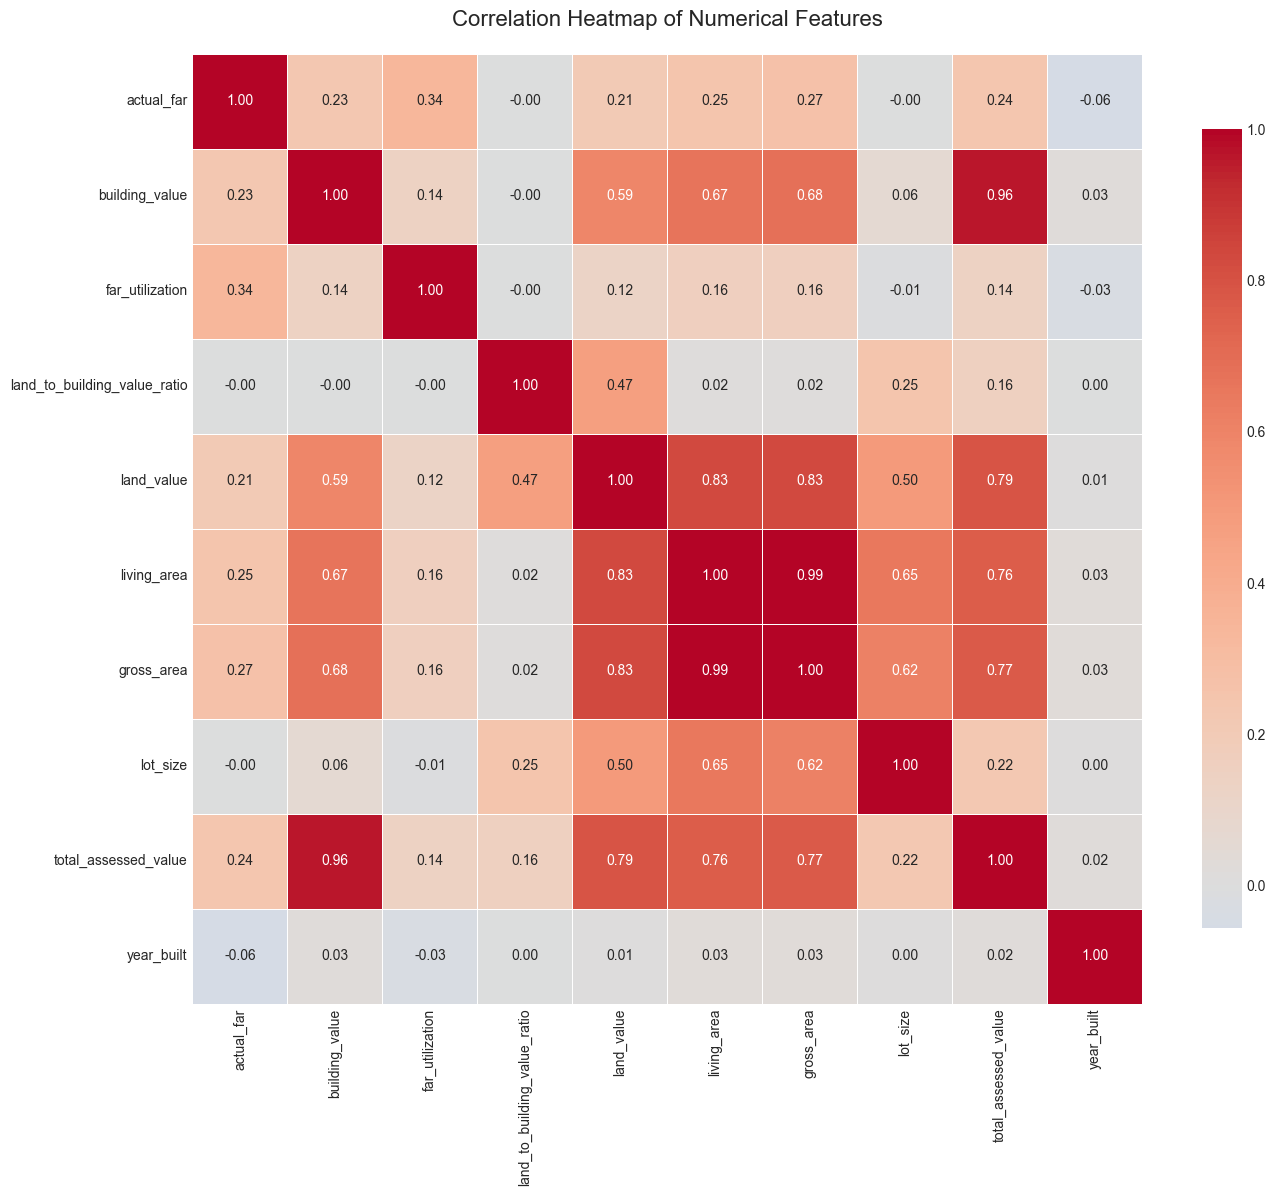

In [13]:
# Correlation heatmap
# Select numerical columns for correlation analysis
# Exclude non-numerical columns and ID columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID columns and other non-feature columns
exclude_cols = ['property_id', 'parcel_id', 'fiscal_year', 'classification_code']
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

# Calculate correlation matrix
corr_matrix = df[numerical_cols].corr()

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Print features with highest correlation with target
if 'high_potential' in corr_matrix.columns:
    target_corr = corr_matrix['high_potential'].sort_values(ascending=False)
    print("Top features correlated with high_potential:")
    print("="*50)
    print(target_corr.head(10))
